In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import sys
sys.path.insert(0,'/Users/mendeza/Documents/projects/cent-tutorial/centernet-tutorial')
from data_gen import ShapeDataset
import matplotlib.pyplot as plt
from PIL import Image
from data import COCODetectionDataset, coco_detection_collate_fn, train_transform_norm, validation_transform_norm
from tqdm import tqdm
import numpy as np
from model import centernet
from loss import centerloss4
from train import train
from utils import pred2box_multiclass, filter_and_nms

<h3> Table of Contents </h3>
<ul>
<li><a href="#Prelims">Prelims</a></li>
<li><a href="#Background">Background</a><ul>
<li><a href="#single-vs-two-stage">Single Stage vs Two Stage</a></li>
<li><a href="#Centernet">Centernet</a></li>
</ul>
<li><a href="#Preprocessing">Preprocessing</a></li>
<ul>
<li><a href="#Encode-Location-as-Gaussian-Keypoints">Encode Location as Gaussian Keypoints</a></li>
<li><a href="#Encode-Width-and-Height">Encode Width and Height</a></li>
</ul>
<li><a href="#Model Architecture">Model Architecture</a></li>
<ul>
<li><a href="#Backbone">Backbone</a></li>
<li><a href="#Class Head">Class Head</a></li>
<li><a href="#Regression Head">Regression Head</a></li>
<li><a href="#Initalization for Focal Loss">Initalization for Focal Loss</a></li>
</ul>
<li><a href="#Loss Function">Loss Function</a></li>
<ul>
<li><a href="#Focal Loss">Focal Loss</a></li>
<li><a href="#Regression Loss">Regression Loss</a></li>
</ul>
<li><a href="#Prepare-Training-Model">Prepare Training Model</a></li>
<li><a href="#Train-Model">Train Model</a></li>
<li><a href="#Evaluate-Loss-Curves">Evaluate Loss Curves</a></li>
<li><a href="#Evaluate-Model-Predictions">Evaluate Model Predictions</a></li>

</ul>


# Prelims

Generate Dataset

In [5]:
s = ShapeDataset(n_images = 2,n_circles=1,n_rectangles=1)
s.gen_dataset()

Num Circle: 1
Num Circle+Rect: 2
Num Anns: 3
[{'segmentation': [], 'area': 3844, 'iscrowd': 0, 'image_id': 1, 'bbox': [287, 142, 62, 62], 'category_id': 0, 'id': 1}, {'segmentation': [], 'area': 1024, 'iscrowd': 0, 'image_id': 1, 'bbox': [102, 41, 32, 32], 'category_id': 1, 'id': 2}]
[{'file_name': 'dummy_1.png', 'height': 512, 'width': 512, 'id': 1}]
Num Circle: 1
Num Circle+Rect: 2
Num Anns: 5
[{'segmentation': [], 'area': 3844, 'iscrowd': 0, 'image_id': 1, 'bbox': [287, 142, 62, 62], 'category_id': 0, 'id': 1}, {'segmentation': [], 'area': 1024, 'iscrowd': 0, 'image_id': 1, 'bbox': [102, 41, 32, 32], 'category_id': 1, 'id': 2}, {'segmentation': [], 'area': 2116, 'iscrowd': 0, 'image_id': 2, 'bbox': [219, 297, 46, 46], 'category_id': 0, 'id': 3}, {'segmentation': [], 'area': 1024, 'iscrowd': 0, 'image_id': 2, 'bbox': [400, 417, 32, 32], 'category_id': 1, 'id': 4}]
[{'file_name': 'dummy_1.png', 'height': 512, 'width': 512, 'id': 1}, {'file_name': 'dummy_2.png', 'height': 512, 'width':

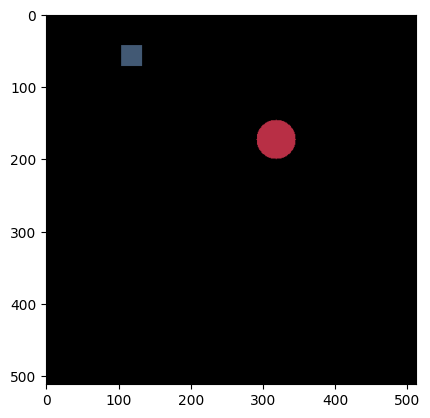

In [6]:
im = Image.open('dummy_1.png')
plt.imshow(im)

In [7]:
ds = COCODetectionDataset(img_dir='/Users/mendeza/Documents/projects/cent-tutorial/centernet-tutorial/tutorial',
                ann_json='/Users/mendeza/Documents/projects/cent-tutorial/centernet-tutorial/tutorial/coco_shapes.json',
                IMG_RESOLUTION=512,
                transform=train_transform_norm)
val_ds = COCODetectionDataset(img_dir='/Users/mendeza/Documents/projects/cent-tutorial/centernet-tutorial/tutorial',
                ann_json='/Users/mendeza/Documents/projects/cent-tutorial/centernet-tutorial/tutorial/coco_shapes.json',
                IMG_RESOLUTION=512,
                transform=validation_transform_norm)
train_loader = torch.utils.data.DataLoader(ds,
                                        batch_size=2,
                                        shuffle=True,
                                        num_workers=8,
                                        pin_memory=True,
                                        collate_fn = coco_detection_collate_fn)
val_loader = torch.utils.data.DataLoader(ds,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=0,
                                        pin_memory=True,
                                        collate_fn = coco_detection_collate_fn)


label_map: {0: 0, 1: 1}
label_map: {0: 0, 1: 1}


In [9]:
len(ds)

2

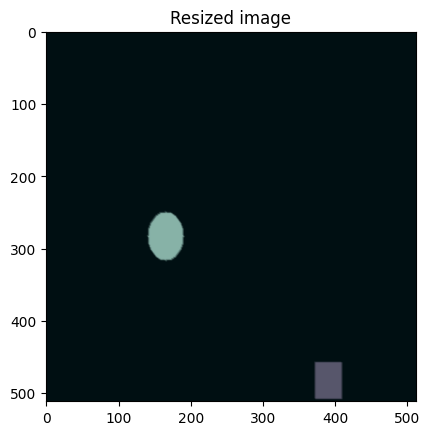

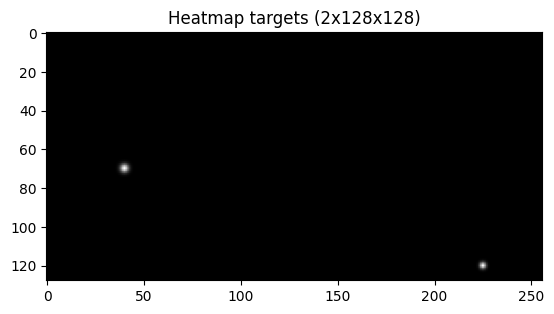

In [13]:
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
img_u = img.transpose(1,2,0)*std + mean# unnormalize
# img = img 
plt.imshow(img_u)
plt.title("Resized image")

plt.show()
c,h,w = hm.shape
nrows = 1
ncols = 2
hm_u = hm.reshape(nrows, ncols, h, w).swapaxes(1,2).reshape(h*nrows, w*ncols)
# hm_u = hm.transpose(1,2,0)
plt.imshow(hm_u,cmap='gray')
plt.title("Heatmap targets (2x128x128)")
plt.show()

# Background

## Single Stage vs Two Stage
<a id='single-vs-two-stage'></a>

## Centernet

# Preprocessing

## Encode Class Keypoints

```python
def draw_umich_gaussian(heatmap, center, radius, k=1):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
  return heatmap
```

## Encoding bounding boxes

```python
centers = np.array([bboxes[:,0]+bboxes[:,2]//2,bboxes[:,1]+bboxes[:,3]//2,bboxes[:,2],bboxes[:,3]]).T
for ind,(c,l )in enumerate(zip(centers,classes)):
    h, w = c[3]/MODEL_SCALE, c[2]/MODEL_SCALE
    radius = gaussian_radius((math.ceil(h), math.ceil(w)))
    radius = max(0, int(radius))
    # print("radius:", radius)
    draw_umich_gaussian(hm[l], [int(c[0])//MODEL_SCALE,int(c[1])//MODEL_SCALE], 
                            radius)
    # draw_msra_gaussian(hm[l], [int(c[0])//MODEL_SCALE,int(c[1])//MODEL_SCALE], 
    #                         radius)
    reg_mask[ind] = 1
    wh[ind] = c[2:]/input_size
    draw_dense_reg(reg,hm[l],c[:2]//MODEL_SCALE,wh[ind],radius)
    inds[ind] = (int(c[1])//MODEL_SCALE)*feature_scale + (int(c[0])//MODEL_SCALE)
```

## Encode Width and Height Regression

```python
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)

  dim = value.shape[0]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value

  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]

  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]

  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    idx = (masked_gaussian >= masked_heatmap).reshape(
      1, masked_gaussian.shape[0], masked_gaussian.shape[1])
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
  return regmap
```

# Model Architecture


## Backbone

```python
if model_name == 'mv3':
            basemodel = torchvision.models.mobilenet_v3_small(pretrained=True)
            num_ch = 576
elif model_name == 'resnet18':
            basemodel = torchvision.models.resnet18(pretrained=True)
            num_ch = 512
basemodel = nn.Sequential(*list(basemodel.children())[:-2])
# set basemodel
self.base_model = basemodel
# Neck
self.up1 = up(num_ch, 512,bilinear=True)
self.up2 = up(512, 256,bilinear=True)
self.up3 = up(256, 256,bilinear=True)
```

## Class Head and Regression Head

```python

# output classification
self.outc = nn.Conv2d(256, n_classes, 1)

self.outr = nn.Conv2d(256, 2, 1)
```

## Initalization of conv layers in Neck for Focal Loss

```python
'''
Author of focal loss:  all new conv layers except the 
final layer, subnets are initalized  with bias b=0 and
a Gaussian weight filled with sigma=0.01

Weight init improves training stability for both the 
cross entropy and focal loss in the case of heavy class
imbalance
'''
for m in self.conv.modules():
    if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight,std=0.01)
        if m.bias is not None:
            nn.init.constant_(m.bias,0)
```

## Initalization of Layers in Head for Focal Loss

```python
'''
Author: the final conv later set the bias
initalization to log((1-pi)/pi)
pi specifies that at the start of training,
every anchor should be labeled as foreground
with confidence of about pi. pi is a variable that is 0.01

This initalization prevents a large number of background 
anchors from generating a large destabalizing loss value in the
in the first iteration of training
'''
self.outc.bias.data.fill_(-2.19)
# output residue
self.outr.bias.data.fill_(-2.19)
def forward(self, x):
batch_size = x.shape[0]
x = self.base_model(x) 

x = self.up1(x)
x = self.up2(x)
x = self.up3(x)
outc = self.outc(x)
outr = self.outr(x)
return outc, outr
```

In [14]:
model = centernet(ds.num_classes,model_name='mv3')

/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Loss Function

# Focal Loss
$$
L_k = \frac{-1}{N} \sum_{xyc}
\begin{cases}
(1 - \hat{Y}_{xyc})^{\alpha} 
        \log(\hat{Y}_{xyc})  & \text{ if } Y_{xyc}=1 \\
\begin{array}{c}
        (1-Y_{xyc})^{\beta} 
        (\hat{Y}_{xyc})^{\alpha}\\
        \log(1-\hat{Y}_{xyc})
        \end{array} & \text{ otherwise }
\end{cases}
$$

```python 
def focal_loss(pred, gt):
  ''' Modified focal loss.
    Arguments:
      pred (batch x h x w)
      gt (batch  x h x w)
  '''
  pos_inds = gt.eq(1).float()
  neg_inds = gt.lt(1).float()
  neg_weights = torch.pow(1 - gt, 4)

  loss = 0
  prob_pred = F.sigmoid(pred)
  pos_loss = F.logsigmoid(pred) * torch.pow(1 - prob_pred, 2) * pos_inds
  neg_loss = F.logsigmoid(1 - pred) * torch.pow(prob_pred, 2) * neg_inds *  neg_weights 

  num_pos  = pos_inds.float().sum()
  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()

  if num_pos == 0:
    loss = loss - neg_loss
  else:
    loss =  loss - (pos_loss + neg_loss) / (num_pos+1e-4)
  return loss
  ```

# Regression Loss
$$
L_{size} = \frac{1}{N}\sum_{k=1}^{N} \left|\hat S_{p_k} - s_k\right|.
$$

```python
def reg_loss(regr, gt_regr, mask):
  ''' L1 regression loss
    Arguments:
      regr (batch x max_objects x dim)
      gt_regr (batch x max_objects x dim)
      mask (batch x max_objects)
  '''
  num = mask.float().sum()
  mask = mask.unsqueeze(2).expand_as(gt_regr).float()

  regr = regr * mask
  gt_regr = gt_regr * mask

  regr_loss = nn.functional.l1_loss(regr, gt_regr, size_average=False)
  regr_loss = regr_loss / (num + 1e-4)
  return regr_loss
  ````

# Prepare and Train Training Model

In [21]:
# LR = 1e-4
LR = 2.5e-4*2
model_mv3, losses, mask_losses, regr_losses = train('mv3',ds.num_classes,learn_rate=LR,epochs=50,train_loader=train_loader,val_loader=val_loader)

/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]

----EPOCH: 0----


/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Loss: 60.206504821777344, Mask Loss: 57.800506591796875, Reg Loss: 2.4059996604919434


  2%|▏         | 1/50 [00:08<06:42,  8.22s/it]

----EPOCH: 1----


Loss: 63.89543533325195, Mask Loss: 61.33489990234375, Reg Loss: 2.5605337619781494


  4%|▍         | 2/50 [00:16<06:30,  8.13s/it]

----EPOCH: 2----


Loss: 48.28178024291992, Mask Loss: 46.32649612426758, Reg Loss: 1.9552844762802124


  6%|▌         | 3/50 [00:24<06:20,  8.10s/it]

----EPOCH: 3----


Loss: 27.7767391204834, Mask Loss: 25.429367065429688, Reg Loss: 2.347372055053711


  8%|▊         | 4/50 [00:32<06:11,  8.08s/it]

----EPOCH: 4----


Loss: 17.507823944091797, Mask Loss: 15.938423156738281, Reg Loss: 1.5694010257720947


 10%|█         | 5/50 [00:40<06:02,  8.06s/it]

----EPOCH: 5----


Loss: 16.41988754272461, Mask Loss: 13.334739685058594, Reg Loss: 3.0851480960845947


 12%|█▏        | 6/50 [00:48<05:53,  8.04s/it]

----EPOCH: 6----


Loss: 13.411704063415527, Mask Loss: 11.057644844055176, Reg Loss: 2.3540589809417725


 14%|█▍        | 7/50 [00:56<05:46,  8.05s/it]

----EPOCH: 7----


Loss: 13.61515998840332, Mask Loss: 11.687363624572754, Reg Loss: 1.9277961254119873


 16%|█▌        | 8/50 [01:04<05:38,  8.05s/it]

----EPOCH: 8----


Loss: 12.158012390136719, Mask Loss: 10.4719877243042, Reg Loss: 1.6860244274139404


 18%|█▊        | 9/50 [01:12<05:30,  8.05s/it]

----EPOCH: 9----


Loss: 10.371551513671875, Mask Loss: 9.09748363494873, Reg Loss: 1.2740674018859863


 20%|██        | 10/50 [01:20<05:21,  8.04s/it]

----EPOCH: 10----


Loss: 12.018522262573242, Mask Loss: 10.603063583374023, Reg Loss: 1.4154582023620605


 22%|██▏       | 11/50 [01:28<05:13,  8.05s/it]

----EPOCH: 11----


Loss: 9.228768348693848, Mask Loss: 7.443946838378906, Reg Loss: 1.78482186794281


 24%|██▍       | 12/50 [01:36<05:06,  8.06s/it]

----EPOCH: 12----


Loss: 8.398039817810059, Mask Loss: 7.185201644897461, Reg Loss: 1.212837815284729


 26%|██▌       | 13/50 [01:44<04:58,  8.05s/it]

----EPOCH: 13----


Loss: 8.038572311401367, Mask Loss: 7.05042839050293, Reg Loss: 0.9881437420845032


 28%|██▊       | 14/50 [01:52<04:49,  8.03s/it]

----EPOCH: 14----


Loss: 7.451196670532227, Mask Loss: 6.215336799621582, Reg Loss: 1.2358598709106445


 30%|███       | 15/50 [02:00<04:41,  8.03s/it]

----EPOCH: 15----


Loss: 7.529455661773682, Mask Loss: 6.219128131866455, Reg Loss: 1.3103276491165161


 32%|███▏      | 16/50 [02:08<04:32,  8.02s/it]

----EPOCH: 16----


Loss: 6.613151550292969, Mask Loss: 5.7938456535339355, Reg Loss: 0.8193057179450989


 34%|███▍      | 17/50 [02:16<04:24,  8.02s/it]

----EPOCH: 17----


Loss: 7.022401332855225, Mask Loss: 5.733043193817139, Reg Loss: 1.2893582582473755


 36%|███▌      | 18/50 [02:24<04:16,  8.01s/it]

----EPOCH: 18----


Loss: 6.69397497177124, Mask Loss: 5.653995990753174, Reg Loss: 1.0399789810180664


 38%|███▊      | 19/50 [02:32<04:08,  8.02s/it]

----EPOCH: 19----


Loss: 6.906583309173584, Mask Loss: 5.441194534301758, Reg Loss: 1.4653888940811157


 40%|████      | 20/50 [02:40<04:00,  8.00s/it]

----EPOCH: 20----


Loss: 5.75040340423584, Mask Loss: 5.171330451965332, Reg Loss: 0.5790731906890869


 42%|████▏     | 21/50 [02:48<03:52,  8.01s/it]

----EPOCH: 21----


Loss: 6.592739105224609, Mask Loss: 5.09008264541626, Reg Loss: 1.5026566982269287


 44%|████▍     | 22/50 [02:56<03:44,  8.01s/it]

----EPOCH: 22----


Loss: 5.848377227783203, Mask Loss: 4.802752494812012, Reg Loss: 1.0456246137619019


 46%|████▌     | 23/50 [03:04<03:36,  8.01s/it]

----EPOCH: 23----


Loss: 5.1604204177856445, Mask Loss: 4.696950912475586, Reg Loss: 0.4634697139263153


 48%|████▊     | 24/50 [03:12<03:28,  8.00s/it]

----EPOCH: 24----


Loss: 5.587155818939209, Mask Loss: 4.537586688995361, Reg Loss: 1.049569010734558


 50%|█████     | 25/50 [03:20<03:20,  8.01s/it]

----EPOCH: 25----


Loss: 5.418884754180908, Mask Loss: 4.486037731170654, Reg Loss: 0.9328469634056091


 52%|█████▏    | 26/50 [03:28<03:12,  8.00s/it]

----EPOCH: 26----


Loss: 5.105047225952148, Mask Loss: 4.205602169036865, Reg Loss: 0.8994452357292175


 54%|█████▍    | 27/50 [03:36<03:04,  8.00s/it]

----EPOCH: 27----


Loss: 5.058488845825195, Mask Loss: 4.250761032104492, Reg Loss: 0.8077277541160583


 56%|█████▌    | 28/50 [03:44<02:55,  8.00s/it]

----EPOCH: 28----


Loss: 6.105315208435059, Mask Loss: 4.232280254364014, Reg Loss: 1.873035192489624


 58%|█████▊    | 29/50 [03:52<02:47,  8.00s/it]

----EPOCH: 29----


Loss: 5.0334792137146, Mask Loss: 4.056198596954346, Reg Loss: 0.9772804975509644


 60%|██████    | 30/50 [04:00<02:40,  8.01s/it]

----EPOCH: 30----


Loss: 4.764255046844482, Mask Loss: 3.824763774871826, Reg Loss: 0.9394910931587219


 62%|██████▏   | 31/50 [04:08<02:32,  8.01s/it]

----EPOCH: 31----


Loss: 5.238545894622803, Mask Loss: 4.215761184692383, Reg Loss: 1.02278470993042


 64%|██████▍   | 32/50 [04:16<02:24,  8.02s/it]

----EPOCH: 32----


Loss: 4.272558212280273, Mask Loss: 3.7165207862854004, Reg Loss: 0.5560373067855835


 66%|██████▌   | 33/50 [04:24<02:16,  8.01s/it]

----EPOCH: 33----


Loss: 4.859798431396484, Mask Loss: 3.9845101833343506, Reg Loss: 0.8752883076667786


 68%|██████▊   | 34/50 [04:32<02:08,  8.02s/it]

----EPOCH: 34----


Loss: 4.520249366760254, Mask Loss: 3.6194217205047607, Reg Loss: 0.9008277654647827


 70%|███████   | 35/50 [04:41<02:00,  8.02s/it]

----EPOCH: 35----


Loss: 4.3808417320251465, Mask Loss: 3.712618827819824, Reg Loss: 0.6682230830192566


 72%|███████▏  | 36/50 [04:49<01:52,  8.03s/it]

----EPOCH: 36----


Loss: 4.09063720703125, Mask Loss: 3.435580015182495, Reg Loss: 0.6550570130348206


 74%|███████▍  | 37/50 [04:57<01:44,  8.04s/it]

----EPOCH: 37----


Loss: 4.086841106414795, Mask Loss: 3.4580118656158447, Reg Loss: 0.6288290619850159


 76%|███████▌  | 38/50 [05:05<01:36,  8.03s/it]

----EPOCH: 38----


Loss: 4.665572166442871, Mask Loss: 3.4904966354370117, Reg Loss: 1.1750755310058594


 78%|███████▊  | 39/50 [05:13<01:28,  8.02s/it]

----EPOCH: 39----


Loss: 4.530832290649414, Mask Loss: 3.4686851501464844, Reg Loss: 1.0621469020843506


 80%|████████  | 40/50 [05:21<01:20,  8.03s/it]

----EPOCH: 40----


Loss: 4.1270647048950195, Mask Loss: 3.1290314197540283, Reg Loss: 0.9980332255363464


 82%|████████▏ | 41/50 [05:29<01:12,  8.02s/it]

----EPOCH: 41----


Loss: 4.1019439697265625, Mask Loss: 3.0526113510131836, Reg Loss: 1.049332857131958


 84%|████████▍ | 42/50 [05:37<01:04,  8.04s/it]

----EPOCH: 42----


Loss: 4.482345104217529, Mask Loss: 3.2701220512390137, Reg Loss: 1.2122231721878052


In [ ]:
len(losses)

3

In [ ]:
# LR = 2.5e-4*2
model_resnet18, losses_resnet18, mask_losses_resnet18, regr_losses_resnet18 = train('resnet18',ds.num_classes,learn_rate=1e-4,epochs=50,train_loader=train_loader,val_loader=val_loader)


  0%|          | 0/50 [00:00<?, ?it/s]

----EPOCH: 0----


0.0018367767 0.34612402 0.99003506


Loss: 34.95229721069336, Mask Loss: 31.19273567199707, Reg Loss: 3.7595632076263428


  2%|▏         | 1/50 [00:08<06:42,  8.21s/it]

----EPOCH: 1----


zero-size array to reduction operation minimum which has no identity


  4%|▍         | 2/50 [00:15<06:04,  7.59s/it]

----EPOCH: 2----


zero-size array to reduction operation minimum which has no identity


  6%|▌         | 3/50 [00:22<05:47,  7.39s/it]

----EPOCH: 3----


zero-size array to reduction operation minimum which has no identity


  8%|▊         | 4/50 [00:29<05:34,  7.27s/it]

----EPOCH: 4----


zero-size array to reduction operation minimum which has no identity


 10%|█         | 5/50 [00:36<05:24,  7.22s/it]

----EPOCH: 5----


zero-size array to reduction operation minimum which has no identity


 12%|█▏        | 6/50 [00:43<05:16,  7.20s/it]

----EPOCH: 6----


zero-size array to reduction operation minimum which has no identity


 14%|█▍        | 7/50 [00:51<05:08,  7.17s/it]

----EPOCH: 7----


zero-size array to reduction operation minimum which has no identity


 16%|█▌        | 8/50 [00:58<05:00,  7.15s/it]

----EPOCH: 8----


zero-size array to reduction operation minimum which has no identity


 18%|█▊        | 9/50 [01:05<04:53,  7.15s/it]

----EPOCH: 9----


zero-size array to reduction operation minimum which has no identity


 20%|██        | 10/50 [01:12<04:46,  7.15s/it]

----EPOCH: 10----


zero-size array to reduction operation minimum which has no identity


 22%|██▏       | 11/50 [01:19<04:38,  7.15s/it]

----EPOCH: 11----


zero-size array to reduction operation minimum which has no identity


 24%|██▍       | 12/50 [01:26<04:31,  7.15s/it]

----EPOCH: 12----


zero-size array to reduction operation minimum which has no identity


 26%|██▌       | 13/50 [01:33<04:24,  7.14s/it]

----EPOCH: 13----


zero-size array to reduction operation minimum which has no identity


 28%|██▊       | 14/50 [01:41<04:17,  7.15s/it]

----EPOCH: 14----


zero-size array to reduction operation minimum which has no identity


 30%|███       | 15/50 [01:48<04:10,  7.15s/it]

----EPOCH: 15----


zero-size array to reduction operation minimum which has no identity


 32%|███▏      | 16/50 [01:55<04:06,  7.24s/it]

----EPOCH: 16----


zero-size array to reduction operation minimum which has no identity


 34%|███▍      | 17/50 [02:02<03:59,  7.26s/it]

----EPOCH: 17----


zero-size array to reduction operation minimum which has no identity


 36%|███▌      | 18/50 [02:10<03:52,  7.27s/it]

----EPOCH: 18----


zero-size array to reduction operation minimum which has no identity


 38%|███▊      | 19/50 [02:17<03:44,  7.24s/it]

----EPOCH: 19----


zero-size array to reduction operation minimum which has no identity


 40%|████      | 20/50 [02:24<03:36,  7.21s/it]

----EPOCH: 20----


zero-size array to reduction operation minimum which has no identity


 42%|████▏     | 21/50 [02:31<03:28,  7.19s/it]

----EPOCH: 21----


zero-size array to reduction operation minimum which has no identity


 44%|████▍     | 22/50 [02:38<03:22,  7.23s/it]

----EPOCH: 22----


zero-size array to reduction operation minimum which has no identity


 46%|████▌     | 23/50 [02:46<03:14,  7.21s/it]

----EPOCH: 23----


zero-size array to reduction operation minimum which has no identity


 48%|████▊     | 24/50 [02:53<03:07,  7.20s/it]

----EPOCH: 24----


zero-size array to reduction operation minimum which has no identity


 50%|█████     | 25/50 [03:00<02:59,  7.19s/it]

----EPOCH: 25----


zero-size array to reduction operation minimum which has no identity


 52%|█████▏    | 26/50 [03:07<02:52,  7.18s/it]

----EPOCH: 26----


zero-size array to reduction operation minimum which has no identity


 54%|█████▍    | 27/50 [03:14<02:45,  7.18s/it]

----EPOCH: 27----


zero-size array to reduction operation minimum which has no identity


 56%|█████▌    | 28/50 [03:21<02:37,  7.17s/it]

----EPOCH: 28----


zero-size array to reduction operation minimum which has no identity


 58%|█████▊    | 29/50 [03:29<02:30,  7.18s/it]

----EPOCH: 29----


zero-size array to reduction operation minimum which has no identity


 60%|██████    | 30/50 [03:36<02:23,  7.18s/it]

----EPOCH: 30----


zero-size array to reduction operation minimum which has no identity


 62%|██████▏   | 31/50 [03:43<02:16,  7.18s/it]

----EPOCH: 31----


zero-size array to reduction operation minimum which has no identity


 64%|██████▍   | 32/50 [03:50<02:09,  7.18s/it]

----EPOCH: 32----


zero-size array to reduction operation minimum which has no identity


 66%|██████▌   | 33/50 [03:57<02:02,  7.18s/it]

----EPOCH: 33----


zero-size array to reduction operation minimum which has no identity


 68%|██████▊   | 34/50 [04:05<01:54,  7.19s/it]

----EPOCH: 34----


zero-size array to reduction operation minimum which has no identity


 70%|███████   | 35/50 [04:12<01:47,  7.17s/it]

----EPOCH: 35----


zero-size array to reduction operation minimum which has no identity


 72%|███████▏  | 36/50 [04:19<01:40,  7.17s/it]

----EPOCH: 36----


zero-size array to reduction operation minimum which has no identity


 74%|███████▍  | 37/50 [04:26<01:33,  7.17s/it]

----EPOCH: 37----


zero-size array to reduction operation minimum which has no identity


 76%|███████▌  | 38/50 [04:33<01:26,  7.19s/it]

----EPOCH: 38----


zero-size array to reduction operation minimum which has no identity


 78%|███████▊  | 39/50 [04:40<01:18,  7.16s/it]

----EPOCH: 39----


zero-size array to reduction operation minimum which has no identity


 80%|████████  | 40/50 [04:48<01:11,  7.15s/it]

----EPOCH: 40----


zero-size array to reduction operation minimum which has no identity


 82%|████████▏ | 41/50 [04:55<01:05,  7.24s/it]

----EPOCH: 41----


zero-size array to reduction operation minimum which has no identity


 84%|████████▍ | 42/50 [05:02<00:57,  7.21s/it]

----EPOCH: 42----


zero-size array to reduction operation minimum which has no identity


 86%|████████▌ | 43/50 [05:09<00:50,  7.20s/it]

----EPOCH: 43----


zero-size array to reduction operation minimum which has no identity


 88%|████████▊ | 44/50 [05:16<00:43,  7.18s/it]

----EPOCH: 44----


zero-size array to reduction operation minimum which has no identity


 90%|█████████ | 45/50 [05:24<00:35,  7.16s/it]

----EPOCH: 45----


zero-size array to reduction operation minimum which has no identity


 92%|█████████▏| 46/50 [05:31<00:28,  7.21s/it]

----EPOCH: 46----


zero-size array to reduction operation minimum which has no identity


 94%|█████████▍| 47/50 [05:38<00:21,  7.20s/it]

----EPOCH: 47----


zero-size array to reduction operation minimum which has no identity


 96%|█████████▌| 48/50 [05:45<00:14,  7.18s/it]

----EPOCH: 48----


zero-size array to reduction operation minimum which has no identity


 98%|█████████▊| 49/50 [05:52<00:07,  7.17s/it]

----EPOCH: 49----


zero-size array to reduction operation minimum which has no identity


100%|██████████| 50/50 [06:00<00:00,  7.20s/it]


# Visualize Loss Curves

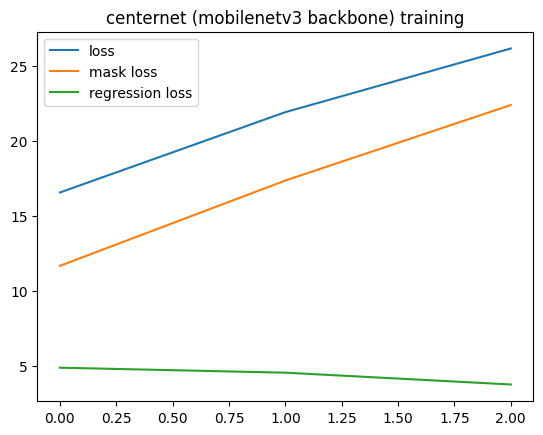

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)),losses )
plt.plot(range(len(losses)),mask_losses)
plt.plot(range(len(losses)),regr_losses)
plt.title("centernet (mobilenetv3 backbone) training")
plt.legend(['loss','mask loss','regression loss'])
plt.show()

In [ ]:
plt.plot(range(len(losses_resnet18)),losses_resnet18 )
plt.plot(range(len(losses_resnet18)),mask_losses_resnet18)
plt.plot(range(len(losses_resnet18)),regr_losses_resnet18)
plt.title("centernet (resnet18 backbone) training")
plt.legend(['loss','mask loss','regression loss'])
plt.show()

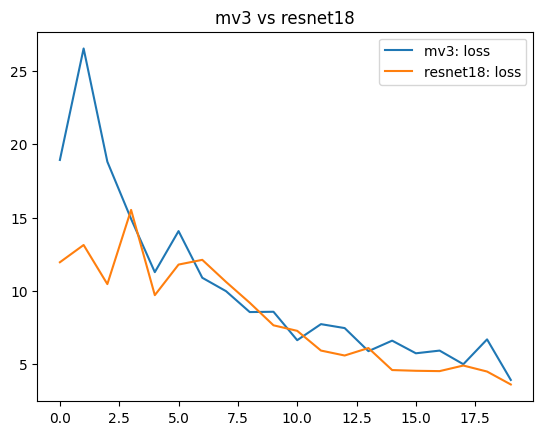

In [ ]:
plt.plot(range(len(losses)),losses )
plt.plot(range(len(losses_resnet18)),losses_resnet18)
plt.title("mv3 vs resnet18")
plt.legend(['mv3: loss','resnet18: loss'])
plt.show()

# Visualize Predictions

In [101]:
# model_mv3(torch.rand(1,3,512,512))

In [137]:
model_mv3.eval()
for img, hm, reg, wh,reg_mask,inds, in_size, out_size, intermediate_size, scale,boxes_aug, target in val_loader:
        break

pred_hm, pred_regs = model_mv3(img)# (4,1,128,128), (4,2,128,128)
pred_hm = torch.sigmoid(pred_hm)
# bboxes,scores,classes = pred2box_multiclass(pred_hm[0].cpu().data.numpy(),
#                                                         pred_regs[0].cpu().detach().numpy(),128,1,thresh=0.0)
bboxes,scores,classes = pred2box_multiclass(pred_hm[0].data.numpy(),pred_regs[0].data.numpy(),128,1,thresh=0.1)
bboxes,scores,classes =  filter_and_nms(bboxes,scores,classes,nms_threshold=0.6,n_top_scores=len(scores))
print(bboxes)

[[128. 128. 128. 128.]
 [128. 128. 128. 128.]
 [128. 128. 128. 128.]
 ...
 [128. 128. 128. 128.]
 [128. 128. 128. 128.]
 [128. 128. 128. 128.]]


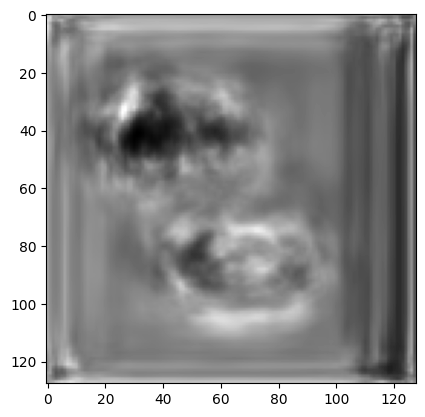

In [138]:
plt.imshow(pred_hm[0].data.numpy()[0],cmap='gray')